# Results
We will compare the three image compression methods discussed on four different images. First, we'll consider the methods separately and see how they handle each of the images. Then, we'll take a single image and compare the results of each method. The goal is to investigate the balance between compression ratio and image quality (both visual and quantitative), and to demonstrate the strengths and weaknesses of each method. 

We will use three quantitative metrics --

<b>Compression Ratio:</b> the ratio of the size of the original image to the size of the compressed image. There was a bit of a challenge here -- I wanted to keep each of the sample images as a `.PNG` as opposed to a lossy format, so that any loss in image quality was only due to the compression algorithm I was testing. But because each image was stored as a `.PNG`, the size of the file on my computer didn't always reflect the steps taken to compress the image. Therefore, I instead estimated the original and compressed file size as the minimum number of bytes needed to store the information contained in the image -- this is detailed in the individual methods section. Because there are lots of different (more efficient) encoding methods than the ones I used, it is likely that the true compressed file sizes would be even smaller. This is particularly true for JPEG compression: I encoded the information by representing the trailing zeros of a block as 2 bytes, but the actual encoding method used in the algorithm usually reads the data in a zig-zag pattern -- this would usually result in even more consecutive zeros.

<b>Mean Squared Error:</b> for original image $I_{m*n}$ and compressed image $I'$,

$$MSE = \frac{1}{MN} \sum_{x=1}^M \sum_{y=1}^N [ I(x,y) - I'(x,y) ]^2.$$

This measures the cumulative squared error between the original and compressed images. A lower value suggests less loss in image quality. For RGB images, we compute the MSE of each matrix then average. 

<b>Peak Signal to Noise Ratio:</b>

$$PSNR = 20 log_{10}(\frac{255}{\sqrt{MSE}})$$

This is a measure of the maximum value of a signal (for RBG images, 255) over the noise introduced by compression (represented by the MSE). The log is introduced to account for the wide dynamic range of many signals. Since we want our compression to introduce as little noise as possible, a higher PSNR suggests higher image quality. 

(Source: https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio )

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [19]:
def MSE(original,compressed):
    size = original.shape[0] * original.shape[1] * original.shape[2]
    dif = (original-compressed)**2
    total = np.sum(dif)
    return(total/size)

In [20]:
def PSNR(original,compressed):
    mse = MSE(original,compressed)
    return(20*np.log10(255/np.sqrt(mse)))

The four test images are `kodim05.png` ("Bikes"), `kodim07.png` ("Flower"), `kodim16.png` ("Ocean"), and `hubble.png` ("Space").

In [73]:
#load original images
kodim05 = cv2.imread("./kodim05.png")
kodim07 = cv2.imread("./kodim07.png")
kodim16 = cv2.imread("./kodim16.png")
hubble = cv2.imread("./hubble.png")

## K-Means Clustering:

In [69]:
#tested values of k
k05 = [8,12,16,32,64]
k07 = [8,12,16,32,64]
k16 = [8,12,16,32,64]
kh = [8,12,16,32]

#compression ratios
kcr05 = [5.114,4.019,3.748,3.044,2.999]
kcr07 = [12.048,8.394,7.625,5.449,4.036]
kcr16 = [9.915,6.678,6.283,4.251,3.169]
kcrh = [4.053,2.999,2.999,2.999]

In [76]:
k05MSE = []
k05PSNR = []

for k in k05:
    c = cv2.imread("./kodims05_"+str(k)+"means.png")
    k05MSE.append(MSE(kodim05,c))
    k05PSNR.append(PSNR(kodim05,c))
    
k07MSE = []
k07PSNR = []

for k in k07:
    c = cv2.imread("./kodims07_"+str(k)+"means.png")
    k07MSE.append(MSE(kodim07,c))
    k07PSNR.append(PSNR(kodim07,c))
    
k16MSE = []
k16PSNR = []

for k in k16:
    c = cv2.imread("./kodims16_"+str(k)+"means.png")
    k16MSE.append(MSE(kodim16,c))
    k16PSNR.append(PSNR(kodim16,c))
    
khMSE = []
khPSNR = []

for k in kh:
    c = cv2.imread("./hubble_"+str(k)+"means.png")
    khMSE.append(MSE(hubble,c))
    khPSNR.append(PSNR(hubble,c))

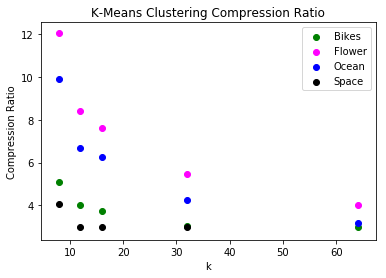

In [65]:
plt.scatter(k05,kcr05,label="Bikes",c="green")
plt.scatter(k07,kcr07,label="Flower",c="magenta")
plt.scatter(k16,kcr16,label="Ocean",c="blue")
plt.scatter(kh,kcrh,label="Space",c="black")
plt.legend()
plt.xlabel("k")
plt.ylabel("Compression Ratio")
plt.title("K-Means Clustering Compression Ratio")
plt.show()

Note that the minimum compression ratio possible with this method is around 3: in this case, we reduce the 3 values of each RGB pixel to a single value. We can see an inflection point in each image, where increasing `k` has diminishing returns on decreasing the compression ratio. 

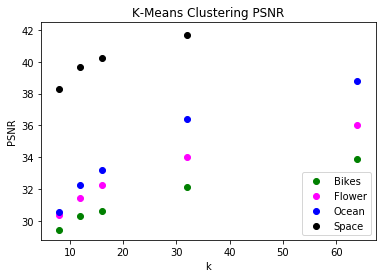

In [66]:
plt.scatter(k05,k05PSNR,label="Bikes",c="green")
plt.scatter(k07,k07PSNR,label="Flower",c="magenta")
plt.scatter(k16,k16PSNR,label="Ocean",c="blue")
plt.scatter(kh,khPSNR,label="Space",c="black")
plt.legend()
plt.xlabel("k")
plt.ylabel("PSNR")
plt.title("K-Means Clustering PSNR")
plt.show()

As we would expect, the more colors we keep in the compressed image, the better the PSNR. Note that the region of most rapid increase in PSNR also coincides with the most rapid decrease in image compression ratio. For higher `k`, we have already represented almost all the colors in the image, so the increase in PSNR slows down. 

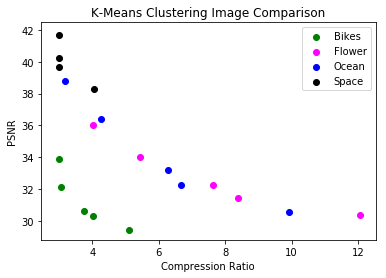

In [68]:
plt.scatter(kcr05,k05PSNR,label="Bikes",c="green")
plt.scatter(kcr07,k07PSNR,label="Flower",c="magenta")
plt.scatter(kcr16,k16PSNR,label="Ocean",c="blue")
plt.scatter(kcrh,khPSNR,label="Space",c="black")
plt.legend()
plt.xlabel("Compression Ratio")
plt.ylabel("PSNR")
plt.title("K-Means Clustering Image Comparison")
plt.show()

As expected, all the tested images have an inverse relation between compression ratio and PSNR. While there will always be this tradeoff, we can also see that performance between images can vary drastically. In general, this is a very good compression technique for images with a relatively low number of distinct colors (eg Space, Ocean), as it guarentees a compression ratio of 3 with minimal introduced noise. The main downside is that this algorithm takes longer to run than the other two, and the runtime increases dramatically with increasing `k` and image size. 

Note that images with large regions of very similar colors (eg Flower and Ocean) can be compressed a large amount, with a moderate loss in PSNR. For images with lots of varying colors (eg Space and Bikes), we cannot compress as much. This method seems to be a particularly bad choice for images with a high number of rapidly varying colors (eg Bikes), as the best compression ratio and PSNR are both relatively low. 

It is worth noting the for a low `k`, sharp edges between colors are introduced -- our eyes may be more perceptive of this than the MSE calculation, since the compressed colors are still relatively close to their original value. 

## Principle Component Analysis:

Here, we can set the degree of compression by choosing to keep the top principle componenets that explain a given percent of the variance. I'll refer to this as `res`, or resolution; `res=0.95` means that we are keeping the first `N` principle components in order to explain 95% of the variance in the original image. 

In [84]:
#tested resolutions
res05 = [0.75,0.8,0.85,0.9,0.93,0.95,0.97,0.98,0.99]
res07 = [0.80,0.85,0.90,0.93,0.95,0.97,0.98,0.99]
res07_idx = [int(r*100) for r in res07] #named these ones wrong
res16 = [0.93,0.95,0.97,0.98,0.99]
resh = [0.7,0.75,0.8,0.85,0.9,0.95,0.99]

rcr05 = [8.486,6.219,4.452,3.042,2.345,1.913,1.5,1.283,1.04]
rcr07 = [13.593,9.91,6.707,4.939,3.869,2.788,2.256,1.664]
rcr16 = [16.879,8.777,4.558,3.167,2]
rcrh = [5.71,4.585,3.648,2.808,2.095,1.437,0.843]

In [86]:
r05MSE = []
r05PSNR = []

for r in res05:
    c = cv2.imread("./kodim05_pcatest_"+str(r)+".png")
    r05MSE.append(MSE(kodim05,c))
    r05PSNR.append(PSNR(kodim05,c))

r07MSE = []
r07PSNR = []

for r in res07_idx:
    c = cv2.imread("./kodim07_pcatest_"+str(r)+".png")
    r07MSE.append(MSE(kodim07,c))
    r07PSNR.append(PSNR(kodim07,c))
    
r16MSE = []
r16PSNR = []

for r in res16:
    c = cv2.imread("./kodim16_pcatest_"+str(r)+".png")
    r16MSE.append(MSE(kodim16,c))
    r16PSNR.append(PSNR(kodim16,c))
    
rhMSE = []
rhPSNR = []

for r in resh:
    c = cv2.imread("./hubble_pcatest_"+str(r)+".png")
    rhMSE.append(MSE(hubble,c))
    rhPSNR.append(PSNR(hubble,c))

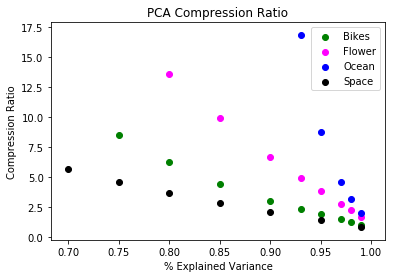

In [87]:
plt.scatter(res05,rcr05,label="Bikes",c="green")
plt.scatter(res07,rcr07,label="Flower",c="magenta")
plt.scatter(res16,rcr16,label="Ocean",c="blue")
plt.scatter(resh,rcrh,label="Space",c="black")
plt.legend()
plt.xlabel("% Explained Variance")
plt.ylabel("Compression Ratio")
plt.title("PCA Compression Ratio")
plt.show()

As the percent of variance in the original image explained by the remaining principle components decreases, the compression ratio increases. Unlike k-means clustering, this relationship appears linear. This is as expected, since keeping fewer principle components means the compressed image will take less space to store. 

More interesting, note that while the relation for each image is linear, the slopes vary drastically. I suspect this is related to the amount of variance in the original image; for example, since Ocean has relatively little varaince to begin with, we need to keep very few principle components to explain a large degree of it. 

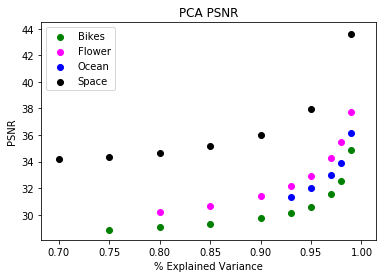

In [132]:
plt.scatter(res05,r05PSNR,label="Bikes",c="green")
plt.scatter(res07,r07PSNR,label="Flower",c="magenta")
plt.scatter(res16,r16PSNR,label="Ocean",c="blue")
plt.scatter(resh,rhPSNR,label="Space",c="black")
plt.legend()
plt.xlabel("% Explained Variance")
plt.ylabel("PSNR")
plt.title("PCA PSNR")
plt.show()

Since Space had the lowest rate of compression, we can see that it also maintains the greatest PSNR with percent explained variance. More interesting is the case of Bikes: it had the 2nd slowest compression rate but it has the lowest PSNR. In other words, it is difficult to compress and it looks bad when we compress it. I suspect this is because although both Space and Bikes are relatively high variance images, Bikes contains a much greater number of colors. 

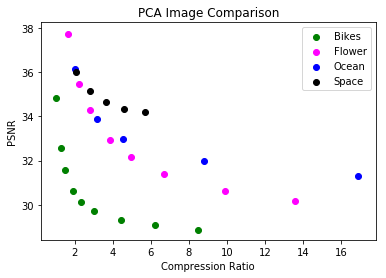

In [130]:
plt.scatter(rcr05,r05PSNR,label="Bikes",c="green")
plt.scatter(rcr07,r07PSNR,label="Flower",c="magenta")
plt.scatter(rcr16,r16PSNR,label="Ocean",c="blue")
plt.scatter(rcrh[:5],rhPSNR[:5],label="Space",c="black")
plt.legend()
plt.xlabel("Compression Ratio")
plt.ylabel("PSNR")
plt.title("PCA Image Comparison")
plt.show()

The shape and relation betwe compression ratio and PSNR for PCA-compressed images is somewhat similar to those for k-mean-compressed images.

For a given compression ratio, PCA performs best on Space, about equal on Flower and Ocean, and worst on Bikes. Again, this is about the same as k-means clustering; this might suggest that Space is simply and easy image to compress, and Bikes is not. It may also be due to our reliance on MSE; Space has many dark colors, so even if some get messed up during compression it won't cause a large increase in MSE. Bikes however has many bright colors; accidentally replacing a blue with a red will cause a much greater increase than replacing a gray with a black.

It is particularly interesting that the "worst" results occur at the inflection point: here we have the lowest possible PSNR for the lowest possible compression ratio. Therefore this algorithm (and k-means as well, to some degree) appears to work best when we either don't compress very much, or when we compress a ton -- of course, neither of these results are what we are usually aiming for with image compression. 

## JPEG Compression

We can vary the degree of compression by multiplying the quantization matrix by a constant, `q`. A larger `q` means greater compression. 

In [107]:
#tested q
q05 = [0.1,0.5,1,2,3,5]
q07 = [0.1,0.5,1,2,3,5]
q16 = [0.1,0.5,1,2,3,5]
qh = [0.1,0.5,1,2,3,5]

#compression ratios
qcr05 = [1.53,2.498,3.292,4.485,5.46,7.216]
qcr07 = [1.817,3.697,5.028,6.996,8.491,10.913]
qcr16 = [1.686,3.301,4.631,6.377,7.858,10.947]
qcrh = [1.429,3.221,5.953,10.194,13.174,17.945]

In [108]:
q05MSE = []
q05PSNR = []

for q in q05:
    c = cv2.imread("./kodim05_"+str(q)+"_jpg.png")
    q05MSE.append(MSE(kodim05,c))
    q05PSNR.append(PSNR(kodim05,c))
    
q07MSE = []
q07PSNR = []

for q in q07:
    c = cv2.imread("./kodim07_"+str(q)+"_jpg.png")
    q07MSE.append(MSE(kodim07,c))
    q07PSNR.append(PSNR(kodim07,c))
    
q16MSE = []
q16PSNR = []

for q in q16:
    c = cv2.imread("./kodim16_"+str(q)+"_jpg.png")
    q16MSE.append(MSE(kodim16,c))
    q16PSNR.append(PSNR(kodim16,c))
    
qhMSE = []
qhPSNR = []

for q in qh:
    c = cv2.imread("./hubble_"+str(q)+"_jpg.png")
    qhMSE.append(MSE(hubble,c))
    qhPSNR.append(PSNR(hubble,c))

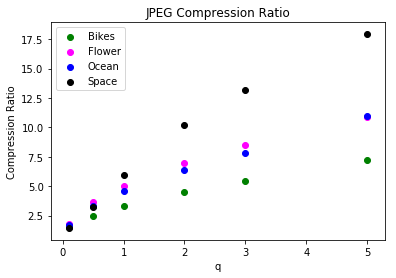

In [109]:
plt.scatter(q05,qcr05,label="Bikes",c="green")
plt.scatter(q07,qcr07,label="Flower",c="magenta")
plt.scatter(q16,qcr16,label="Ocean",c="blue")
plt.scatter(qh,qcrh,label="Space",c="black")
plt.legend()
plt.xlabel("q")
plt.ylabel("Compression Ratio")
plt.title("JPEG Compression Ratio")
plt.show()

The JPEG algorithm allows for high levels of compression; it is worth noting that there is an upper bound on this compression ratio, and the rate of compression increase with `q` tapers off as we near this boundary.

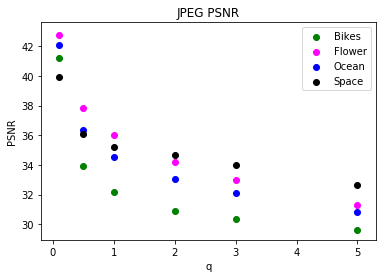

In [113]:
plt.scatter(q05,q05PSNR,label="Bikes",c="green")
plt.scatter(q07,q07PSNR,label="Flower",c="magenta")
plt.scatter(q16,q16PSNR,label="Ocean",c="blue")
plt.scatter(qh,qhPSNR,label="Space",c="black")
plt.legend()
plt.xlabel("q")
plt.ylabel("PSNR")
plt.title("JPEG PSNR")
plt.show()

Interestingly, we see that Space has the worst compression at low `q` but the best compression at high `q`. On the other hand, Ocean and Bikes drop off particularly fast at higher `q`. One aspect of image quality that PSNR does not quite capture is image artifacting -- this is particularly prominent at boundaries of sharply contrasting colors. 

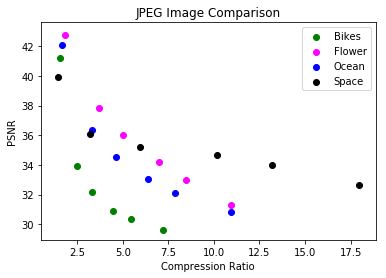

In [114]:
plt.scatter(qcr05,q05PSNR,label="Bikes",c="green")
plt.scatter(qcr07,q07PSNR,label="Flower",c="magenta")
plt.scatter(qcr16,q16PSNR,label="Ocean",c="blue")
plt.scatter(qcrh,qhPSNR,label="Space",c="black")
plt.legend()
plt.xlabel("Compression Ratio")
plt.ylabel("PSNR")
plt.title("JPEG Image Comparison")
plt.show()

In general, JPEG is a very good image compression algorithm and almost always outperforms the others tested for any image. However, the main drawback is the occurence of very noticeable artifacting around boundaries of sharply contrasting colors. A more complete JPEG compression algorithm would likely also contain a dithering step to counteract this. Because of this prominent artifacting, JPEG compression tends to perform best on images with few areas of sharp color contrast. 

## Side-by-Side Comparison
Since no one method seems to handle a particular type of image significantly better than any other, it makes sense to run a side-by-side comparison of each method on a single image. 

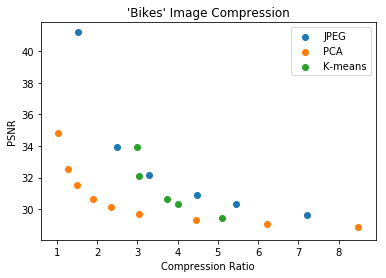

In [127]:
plt.scatter(qcr05,q05PSNR,label="JPEG")
plt.scatter(rcr05,r05PSNR,label="PCA")
plt.scatter(kcr05,k05PSNR,label="K-means")
plt.legend()
plt.xlabel("Compression Ratio")
plt.ylabel("PSNR")
plt.title("'Bikes' Image Compression")
plt.show()

In general, JPEG performed best on the bikes image. K-means performed nearly as well, but has the significant disadvantage of taking many times longer to run. Again, both k-means and JPEG compression would benefit significantly from dithering. PCA does not perform competitevly at lower compression ratios, but may be a reasonable option at very large compression ratios. 

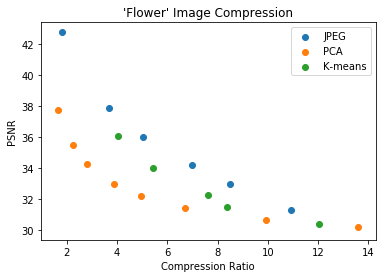

In [120]:
plt.scatter(qcr07,q07PSNR,label="JPEG")
plt.scatter(rcr07,r07PSNR,label="PCA")
plt.scatter(kcr07,k07PSNR,label="K-means")
plt.legend()
plt.xlabel("Compression Ratio")
plt.ylabel("PSNR")
plt.title("'Flower' Image Compression")
plt.show()

The same pattern arises here: JPEG performs best, followed by k-means clustering, then finally PCA. 

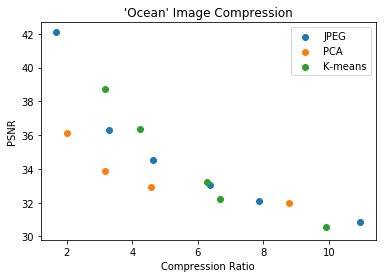

In [125]:
plt.scatter(qcr16,q16PSNR,label="JPEG")
plt.scatter(rcr16[1:],r16PSNR[1:],label="PCA")
plt.scatter(kcr16,k16PSNR,label="K-means")
plt.legend()
plt.xlabel("Compression Ratio")
plt.ylabel("PSNR")
plt.title("'Ocean' Image Compression")
plt.show()

K-means performs surprisingly well here, especially at lower compression ratios. That said, I believe this is mostly a consequence of the selected colors being "close enough" to not have much impact on the MSE. K-means still exhibits prominent color banding that is not visible with JPEG at this compression ratio. Still, this result demonstrates that k-means has potential in images with few colors and larges similar-colored blocks. 

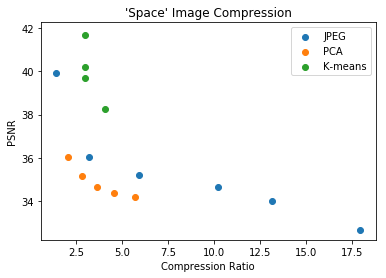

In [134]:
plt.scatter(qcrh,qhPSNR,label="JPEG")
plt.scatter(rcrh[:5],rhPSNR[:5],label="PCA")
plt.scatter(kcrh,khPSNR,label="K-means")
plt.legend()
plt.xlabel("Compression Ratio")
plt.ylabel("PSNR")
plt.title("'Space' Image Compression")
plt.show()

Here we again see that k-means clustering can be used very effectively to compress the image by a factor of 3. Because the original image has relatively few colors, k-means is a good choice here. However, the downside is that it takes significantly longer to run than JPEG compression. 

Across all the tested images, we see that JPEG performs the best in general. Note that the form of JPEG tested here is a pared-down version of the actual method, which would perform even better. Still, JPEG tends to cause very noticeable artifacting on high-color-contrasting boundaries, which would require a further dithering step to correct. 

K-means tends to perform best on images with a limited number of colors; in these cases it can even outperform JPEG. The main downside of k-means is that it takes a significant amount of time to run. Additionally, there is no way of knowing what value of `k` to select beforehand to get the most efficient compression. Overall, k-means clustering is a powerful technique and may be made better suited for image compression by making some educated guesses about the image beforehand. 

PCA is another very powerful technique, but is simply not optimized for this type of image compression. While it is similar in process to JPEG compression, it does not take the same steps to account for how our vision works. However, PCA does have other interesting applications in image processing, such as describing large numbers of images by a common set of basis vectors. 

Finally, note that none of these methods needs to be taken as stand-alone. Many advanced and very efficient image compression techniques combine bits and pieces of the techniques presented here, as well as from other methods. 